# Data Cleaning and Exploration

## Initialization

In [1]:
#Python Data Analysis imports
import pandas as pd
import numpy as np

#Visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#To grab stock data
import pandas_datareader.data as web
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
from datetime import datetime as dt
import datetime
import calendar

# Caching
import requests_cache

In [2]:
# American Airlines Group Inc. (AAL), # Delta Air Lines, Inc. (DAL)
stock_names = {'AAL': 'American Airlines Group Inc.', 'DAL': 'Delta Air Lines, Inc.'}
airline_stocks = ['AAL', 'DAL']
AAL, DAL = None, None
start = dt(2015, 1, 1)
end = dt(2020, 1, 1)

Making the same request repeatedly can use a lot of bandwidth, slow down your code and may result in your IP being banned.
We might not need to cache...

In [3]:
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

In [4]:
def load_stocks(stocks, start, end):
    """
    Loads stock data from Yahoo Finance.
    """
    for stock in stocks:
        try:
            globals()[stock] = web.DataReader(stock, 'yahoo', start, end, session=session) # default interval is 1day
        except Exception as  e:
            print('Error downloading: ' + stock, "error: ", e)
            return
    print('Data loaded successfully.')

In [5]:
load_stocks(airline_stocks, start, end)

Data loaded successfully.


## Data Cleaning

Features - Airline Stocks:
- High - High price of the stock
- Low - Low price of the stock
- Open - Open price of the stock
- Close - Close price of the stock
- Volume - Volume of the stock

### Airline Stocks

In [6]:
print(AAL.shape)
AAL.head()

(1258, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,54.599998,53.070000,54.279999,53.910000,10748600.0,51.079906
2015-01-05,54.540001,53.340000,54.369999,53.880001,11565000.0,51.051498
2015-01-06,54.430000,52.130001,54.270000,53.040001,13772200.0,50.255589
2015-01-07,53.650002,52.119999,53.380001,53.009998,10069800.0,50.227154
2015-01-08,54.279999,53.250000,53.480000,53.660000,9672100.0,50.843029


In [7]:
print(AAL.shape)
DAL.head()

(1258, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,50.009998,48.709999,49.919998,49.180000,8637300.0,44.267334
2015-01-05,49.480000,47.810001,49.459999,48.360001,10556500.0,43.529232
2015-01-06,48.740002,46.250000,48.549999,47.220001,12880400.0,42.503117
2015-01-07,47.590000,46.509998,47.480000,46.970001,10516200.0,42.278084
2015-01-08,48.320000,47.259998,47.480000,48.189999,10499300.0,43.376213


Check for missing values

In [8]:
def show_airline_stock_missing_values():
    missing_values = pd.DataFrame(index=["High", "Low", "Open", "Close", "Volume"], columns=airline_stocks)
    for stock in airline_stocks:
        missing_values[stock] = globals()[stock].isnull().sum()
    return missing_values

show_airline_stock_missing_values()

,AAL,DAL
High,0,0
Low,0,0
Open,0,0
Close,0,0
Volume,0,0


In [9]:
def airline_stock_extract_dates():
    for stock in airline_stocks:
        df_stock = globals()[stock]
        df_stock['Day'], df_stock['Month'], df_stock['Year'] = df_stock.index.day, df_stock.index.month, df_stock.index.year

airline_stock_extract_dates()
AAL.head(2)

,High,Low,Open,Close,Volume,Adj Close,Day,Month,Year
Date,,,,,,,,,
2015-01-02,54.599998,53.07,54.279999,53.910000,10748600.0,51.079906,2,1,2015
2015-01-05,54.540001,53.34,54.369999,53.880001,11565000.0,51.051498,5,1,2015


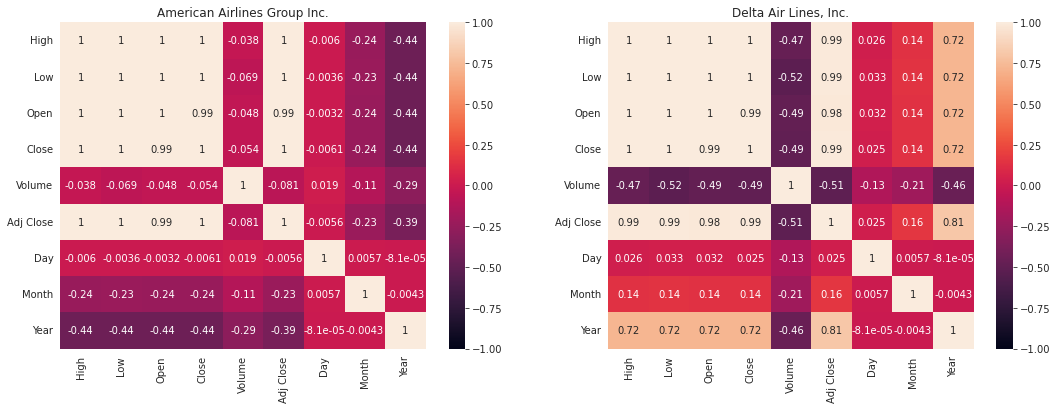

In [10]:
def airline_stock_corr():
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    for i, stock in enumerate(airline_stocks):
        ax[i].set_title(stock_names[stock])
        sns.heatmap(globals()[stock].corr(), vmin=-1, vmax=1,  ax=ax[i], annot=True)

airline_stock_corr()

TODO - No need to remove any columns?

### Other Stocks

...

## Exploratory Data Analysis

In [11]:
def open_close_prices_per_airline(years:list):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for i, stock in enumerate(airline_stocks):
        df_stock = globals()[stock]
        df_stock = df_stock.loc[df_stock["Year"].isin(years)]

        ax[i].set_title(stock_names[stock] + " - " + ",".join(str(year) for year in years))
        df_stock.plot(y=['Open','Close'], ax=ax[i])

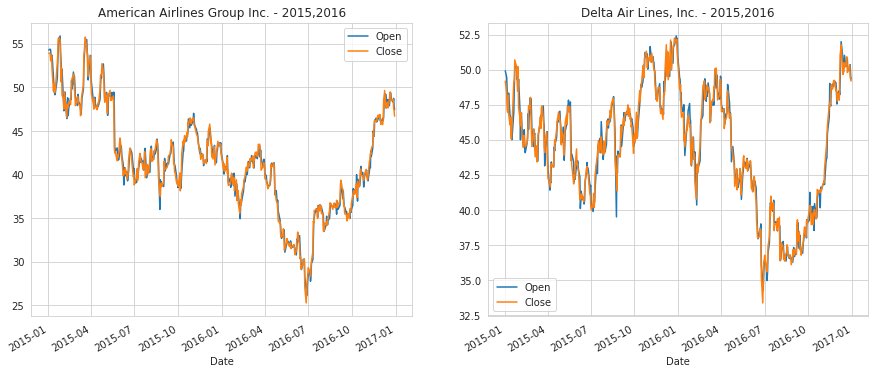

In [12]:
open_close_prices_per_airline([2015, 2016])

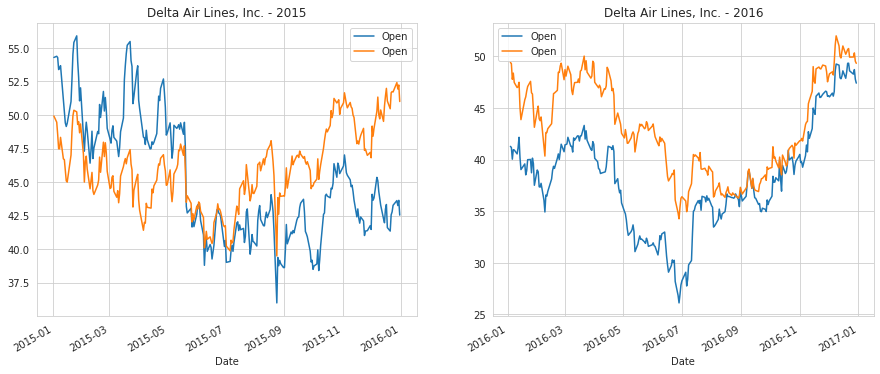

In [22]:
# now we will match stock increases and decreases, per year
def airline_stock_increase_decrease_per_year(years:list):
    fig, ax = plt.subplots(1, len(years), figsize=(15, 6))
    for i, year in enumerate(years):
        for j, stock in enumerate(airline_stocks):
            df_stock = globals()[stock]
            df_stock = df_stock.loc[df_stock["Year"].isin([year])]

            ax[i].set_title(stock_names[stock] + " - " + str(year))
            df_stock.plot(y=['Open'], ax=ax[i])

airline_stock_increase_decrease_per_year([2015, 2016])

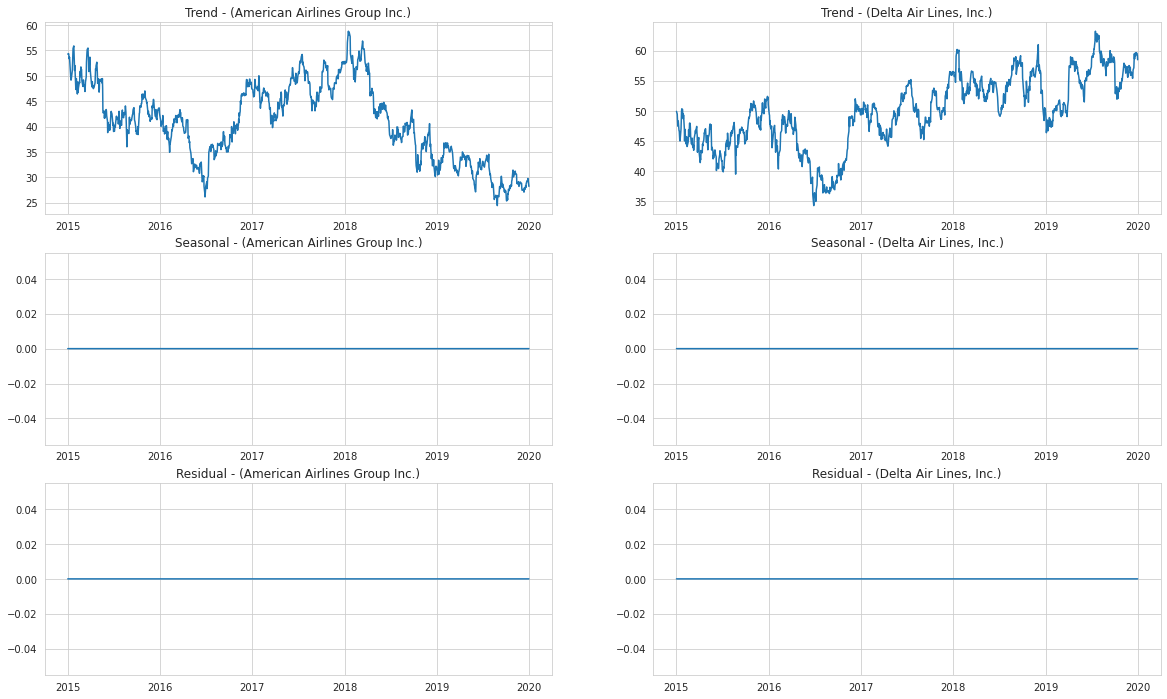

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
def airline_stock_seasonality_and_trends(feature='Open', model='additive', period=1):
    fig, ax = plt.subplots(3, 2, figsize=(20, 12))
    for i, stock in enumerate(airline_stocks):
        df_stock = globals()[stock]
        df_stock_decompose = seasonal_decompose(df_stock[feature], model=model, period=period)

        ax[0, i].plot(df_stock_decompose.trend)
        ax[0, i].set_title(f"Trend - ({stock_names[stock]})")
        ax[1, i].plot(df_stock_decompose.seasonal)
        ax[1, i].set_title(f"Seasonal - ({stock_names[stock]})")
        ax[2, i].plot(df_stock_decompose.resid)
        ax[2, i].set_title(f"Residual - ({stock_names[stock]})")

airline_stock_seasonality_and_trends()

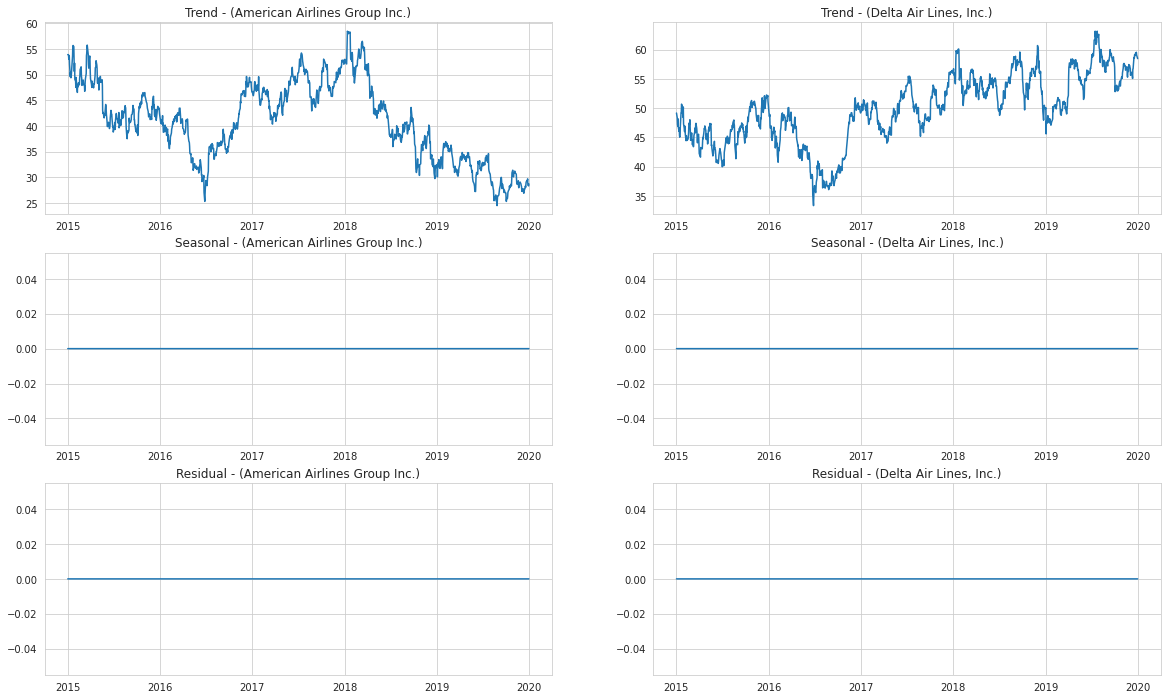

In [48]:
airline_stock_seasonality_and_trends("Close")

<AxesSubplot:xlabel='Date'>

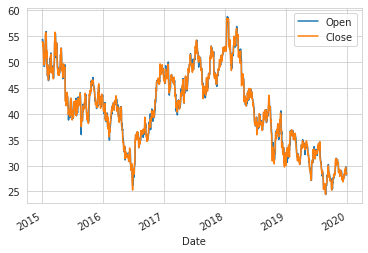

In [110]:
AAL.plot(y=['Open','Close'])

Save the stocks to csv file

In [50]:
def Save_Stock_Data(path="data/"):
    for stock in airline_stocks:
        df_stock = globals()[stock]
        df_stock.to_csv(f"{path}{stock}.csv")
Save_Stock_Data()